In [1]:
import torch
import matplotlib.pyplot as plot
import torch.nn.functional as F

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()

In [3]:
print(f'num of words: {len(words)}')
print(f'first 10 words: {words[:10]}')

num of words: 32033
first 10 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
# A bigram language model we're only working with two characters at a time. We're looking at one character and trying to predict what comes next.
# let's look at first few bigrams in our dataset
bigram_freq = {}
for w in words[:3]:
    chars = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        bigram_freq[bigram] = bigram_freq.get(bigram, 0) + 1 # count the frequency of bigram and update it
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [5]:
bigram_freq

{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

In [6]:
bigram_freq = {}
for w in words:
    chars = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        bigram_freq[bigram] = bigram_freq.get(bigram, 0) + 1  # count the frequency of bigram and update it

In [7]:
len(bigram_freq)

627

In [8]:
list(bigram_freq.items())[:5]

[(('<S>', 'e'), 1531),
 (('e', 'm'), 769),
 (('m', 'm'), 168),
 (('m', 'a'), 2590),
 (('a', '<E>'), 6640)]

In [9]:
# bigrams sorted by likeliness
sorted_bigrams = sorted(bigram_freq.items(), key = lambda kv: -kv[1])
sorted_bigrams[:5]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

In [10]:
# bigram freqs as tensor
bi_fq_tensor = torch.zeros((27, 27), dtype=torch.int32)

In [11]:
# build vocabulary of tokens
chars = sorted(list(set(''.join(words))))
char_to_int_map = {ch:i+1 for i, ch in enumerate(chars)}
char_to_int_map['.'] = 0
char_to_int_map

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [12]:
int_to_ch_map = {i:ch for ch, i in char_to_int_map.items()}
int_to_ch_map

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [13]:
for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        bi_fq_tensor[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

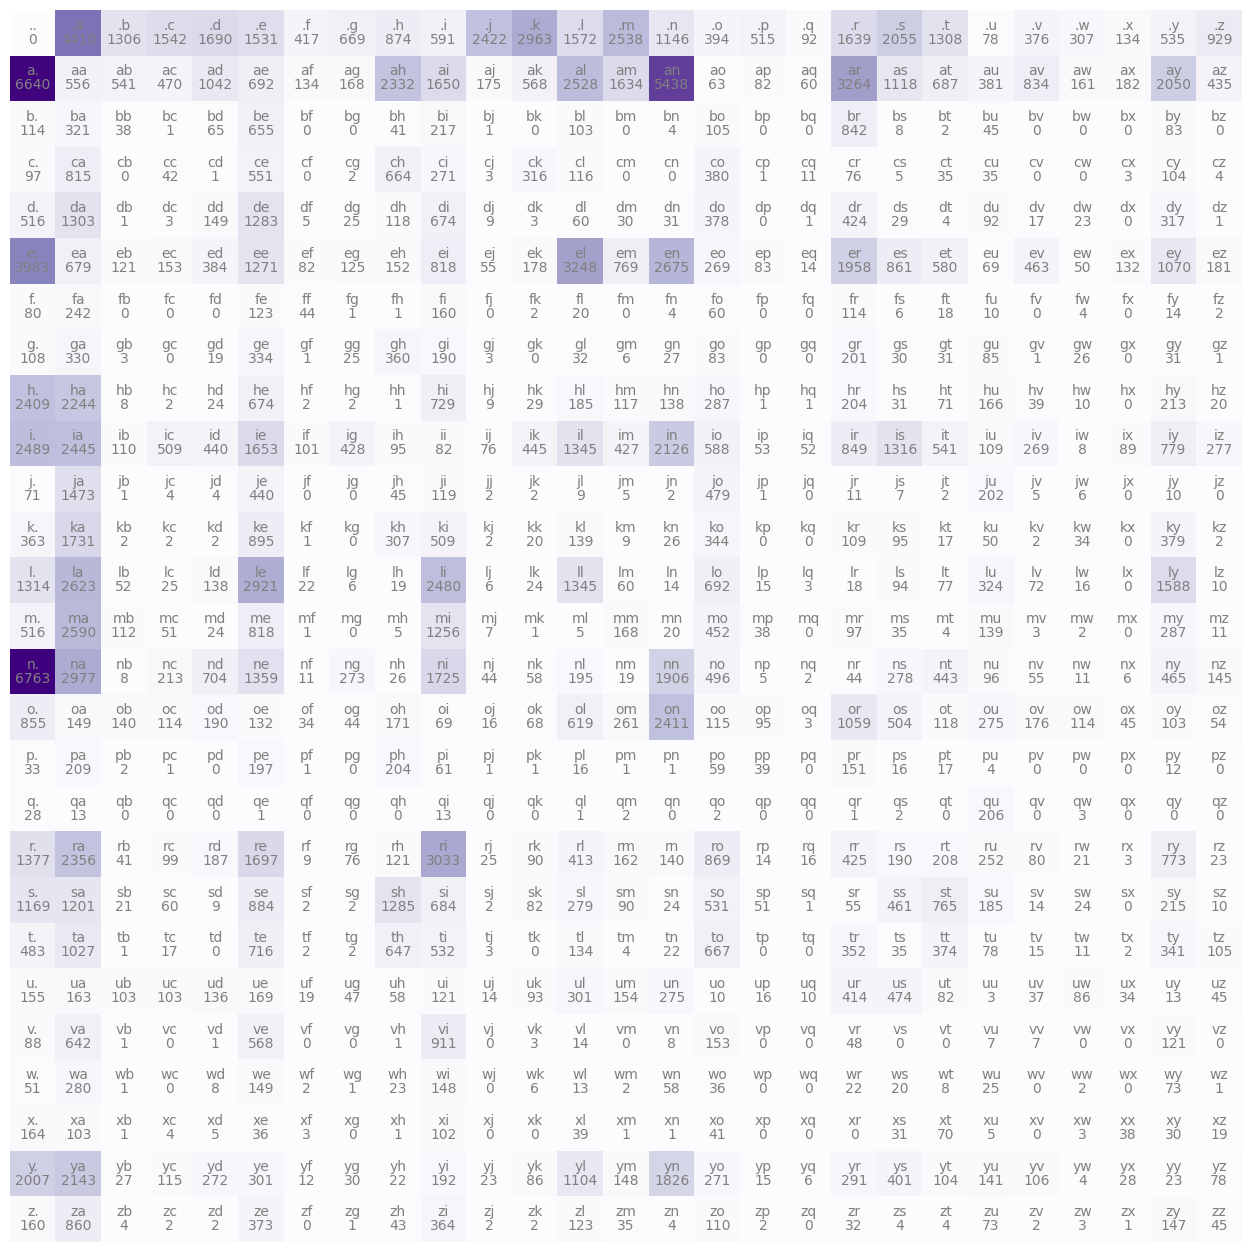

In [14]:
plot.figure(figsize=(16,16))
plot.imshow(bi_fq_tensor, cmap='Purples')
for i in range(27):
    for j in range(27):
        chstr = int_to_ch_map[i] + int_to_ch_map[j]
        plot.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plot.text(j, i, bi_fq_tensor[i, j].item(), ha='center', va='top', color='gray')
plot.axis('off')

In [15]:
# first row of tensor
bi_fq_tensor[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [16]:
# sum of all counts
bi_fq_tensor.sum()

tensor(228146)

In [17]:
# get probability of any char to be the first character of the word
probs = bi_fq_tensor[0].float()
probs = probs / probs.sum()
probs

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [18]:
# an example of sampling from a distribution
ex_p = torch.rand(3)
ex_p = ex_p / ex_p.sum()
print(f'example probabilities: {ex_p}\n')
# torch.multinomial picks out samples from a probability distribution 
torch.multinomial(ex_p, num_samples=20, replacement=True) # replacement = true means that an element can be sampled again after being sampled

# notice that the elements in the sample are according to their probabilities in the distribution

example probabilities: tensor([0.3271, 0.4734, 0.1995])



tensor([0, 0, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1, 1])

In [19]:
# sampling from our distribution
idx = torch.multinomial(probs, num_samples=1, replacement=True)
print(f'idx: {idx}\n')
idx = idx.item()
print(f'idx: {idx}\n')
print(f'sample char: {int_to_ch_map[idx]}\n')

idx: tensor([18])

idx: 18

sample char: r



In [20]:
# sample next character for word that begins with m
for i in range(10):
    samples = []
    idx = 0
    while True:
        p = bi_fq_tensor[idx].float()
        p = p / p.sum()
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        samples.append(int_to_ch_map[idx])
        if idx == 0:
            # break when you reach the end token
            break
    print(''.join(samples))

# the poor results are because we are only using a Bigram model which only looks at a single character to predict the next one.

s.
krladube.
kae.
quch.
jahaccllemi.
x.
amo.
c.
leemanavanony.
yndazya.


In [21]:
# to check if our modal is including probabilities we make everything equally likely and see the output
# its much worse because there is no "training"
for i in range(10):
    samples = []
    idx = 0
    while True:
        p = torch.ones(27) / 27.0
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        samples.append(int_to_ch_map[idx])
        if idx == 0:
            # break when you reach the end token
            break
    print(''.join(samples))

dqwouylsadq.
dxrdsbbipqpurrvhagkpjxlvvz.
i.
xclknagzqo.
papyzchsqikgimnlewgfgwkovggb.
norhljchgbqfilr.
rljcnfmaynbhaccnrbpjojqntpzdpyyzcj.
kyzhjkojnbnxccvmprcpunhpchluakgdxhgewqmep.
.
zsgvihadyikfltkdiropykwxquaatfrjrxfvbzhhq.


## Optimizing Probability Calculation Using Matrices

Instead of calculating the sum and performing division in every iteration of the loop. We can use tensor operations to calcluate probabilies of every bigram in a very efficient manner by leverging broadcasting.

**Boardcasting is a key operation when working with Tensors so look into this more.**

In [22]:
Probs = bi_fq_tensor.float()

In [23]:
Probs.shape

torch.Size([27, 27])

In [24]:
Probs.sum()

tensor(228146.)

In [25]:
Probs.sum(1, keepdim=True).shape

torch.Size([27, 1])

In [26]:
Probs = Probs / Probs.sum(1, keepdim=True)

By updating our sampling method to use `Probs` we get:

In [27]:
for i in range(10):
    samples = []
    idx = 0
    while True:
        p = Probs[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        samples.append(int_to_ch_map[idx])
        if idx == 0:
            # break when you reach the end token
            break
    print(''.join(samples))


kydyeyelaizlis.
kathnelay.
mmaharey.
phakon.
deleydamindin.
data.
ds.
don.
illashe.
jan.


## Loss Function

## Likelihood

Likelihood is used as a metric to get an idea of how well the model is performing. It's calculated as the product of all these probabilities. It gives the probability of the entire dataset assigned by the model. The closer that figure is to 1, the better the model is performing.

### Log Likelihood

Since these probabilities are small numbers less than 1, their product is a number even smaller. So for convenience we use take the log of these probabilities. The sum of these probabilities is called the log likelihood.

In [28]:
log_likelihood = 0.0

for w in words[:3]:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        prob = Probs[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4}')

print(f'log likelihood: {log_likelihood}')       

.e: 0.0478 -3.041
em: 0.0377 -3.279
mm: 0.0253 -3.677
ma: 0.3899 -0.9418
a.: 0.1960 -1.63
.o: 0.0123 -4.398
ol: 0.0780 -2.551
li: 0.1777 -1.728
iv: 0.0152 -4.187
vi: 0.3541 -1.038
ia: 0.1381 -1.98
a.: 0.1960 -1.63
.a: 0.1377 -1.983
av: 0.0246 -3.704
va: 0.2495 -1.388
a.: 0.1960 -1.63
log likelihood: -38.78563690185547


### Negative Log Likelihood

Our log likelihood came to be a negative number which makes sense because `log(1) = 0` and numbers below 1 have a negative log. We can't use this function as is as a loss function because for a loss function lower is better. That means better probabilities should result in a lower loss instead of the other way around. So we take the negative log likelihood as our loss function.

NLL is a good loss function because the lowest it can get is 0 (for prob = 0) and the higher it is, the worse are the predictions.

In [29]:
nll = - log_likelihood
print(f'negative log likelihood: {-log_likelihood}')

negative log likelihood: 38.78563690185547


One last thing to do in this loss function is to normalize it by taking it as an average instead of a sum.

In [30]:
log_likelihood = 0.0
n = 0

for w in words[:3]:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        prob = Probs[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'loss: {-log_likelihood / n}')  # average negative log likelihood

loss: 2.424102306365967


### Model Smoothing

If we have a bigram which has zero probability then it's loss will be infinity which is undesirable. To fix these we use model smoothing. We do this by adding some fake counts.

In [31]:
-torch.log(torch.tensor(0))

tensor(inf)

In [32]:
# add a count of 1 for every sample to prevent zeros
# this number can be any constant
# the more you add the more uniform model we'll have
# using smaller numbers will a peaked model
Probs = (bi_fq_tensor + 1).float() 
Probs = Probs / Probs.sum(1, keepdim=True)

## Using A Neural Net

### Building A Training Set

In [33]:
inputs, targets = [], []

for w in words[:1]:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = char_to_int_map[ch1]
        ix2 = char_to_int_map[ch2]
        print(ch1, ch2)
        inputs.append(ix1)
        targets.append(ix2)

# create tensors from the lists
inputs = torch.tensor(inputs)        
targets = torch.tensor(targets)

. e
e m
m m
m a
a .


In [34]:
print(f'inputs: {inputs}\n') # . e m m a
print(f'targets: {targets}\n') # e m m a .

inputs: tensor([ 0,  5, 13, 13,  1])

targets: tensor([ 5, 13, 13,  1,  0])



### Neural Network

Neural Networks are made up of neurons which have weights assciated with them. These weights act multiplicatively on the inputs to generate activations. 

Our network will take a single character as input, inact its weights and output a probability distribution over the next character in the sequence. We'll be able to evaluate the weights of the model through our loss function. We'll use gradient based optimization to tune the weights to give better output.

### One Hot Encoding

A one-hot vector is a 1 × N matrix (vector) used to distinguish each word in a vocabulary from every other word in the vocabulary. The vector consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify the word. One-hot encoding ensures that machine learning does not assume that higher numbers are more important.

We'll use it to encode our integers. For example while encoding the integer 13, all values in the vector will be 0 except the 13th dimension which will be 1. This vector will be the input to our NN. 

In [37]:
inputs_enc = F.one_hot(inputs, num_classes=27) # num_classes is how large the vector should be. We have 27 ints in our vocab hence 27
inputs_enc

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

In [38]:
inputs_enc.shape

torch.Size([5, 27])

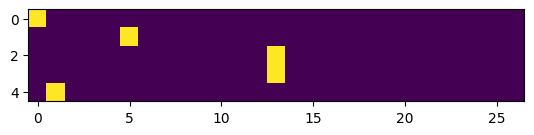

In [39]:
plot.imshow(inputs_enc)

We've encoded the small example batch into vectors. Notice that the appropriate bit is turned on as a 1 and everything else is 0.

**Note:** when we plug numbers into a neural network, we want them as floating point numbers instead of integers so make sure to check the `dtype`.

In [40]:
inputs_enc.dtype 

torch.int64

In [41]:
# we'll have to cast our encoding to float
inputs_enc = F.one_hot(inputs, num_classes=27).float()
inputs_enc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [42]:
inputs_enc.dtype

torch.float32

### Constructing A Neuron

Each neuron in a NN performs the operation a = wx + b, where a are the activations for the next layer, w are the weights of that layer, x is the input vector and b is the bias.

In [44]:
# initialize the weights of a neuron
w = torch.randn((27, 1)) # passing the size as 27, 1
w

tensor([[-0.1357],
        [ 0.4552],
        [-0.7455],
        [ 2.0147],
        [-0.9040],
        [ 1.5739],
        [-1.8803],
        [-0.4414],
        [ 1.9259],
        [ 2.5475],
        [ 0.1759],
        [-0.5460],
        [-1.4241],
        [-0.1879],
        [ 1.2481],
        [ 0.8906],
        [-0.9527],
        [-0.0524],
        [ 0.9967],
        [ 1.3727],
        [-1.0931],
        [ 0.2941],
        [-1.0597],
        [-0.7851],
        [ 1.2247],
        [ 0.8601],
        [-0.8155]])

In [46]:
# performing matmul of inputs with w
inputs_enc @ w # 5, 27 * 27, 1 -> 5, 1 

tensor([[-0.1357],
        [ 1.5739],
        [-0.1879],
        [-0.1879],
        [ 0.4552]])

`w` represents the 5 activations of this neuron on these 5 inputs. We evaluated (performed the operation w.x + b with b=0) all of them in parallel using pytorch.

Next up, instead of having just 1 neuron we'll have 27 neurons.

In [57]:
w = torch.randn((27, 27))
inputs_enc @ w # evaluate all 27 neurons on all 5 inputs in parallel

tensor([[ 0.3627, -0.5262,  0.2405,  0.5672, -0.4336,  1.2020, -0.8258, -0.2946,
          1.3540,  1.4214,  0.7094,  1.3707,  0.7605, -0.5688,  0.2290, -0.9192,
          0.4689,  0.7503,  1.7211, -1.5852, -1.0651,  1.3767, -0.4650, -0.1940,
         -1.1808,  0.7065, -1.2553],
        [ 1.1659,  0.5052,  0.4963,  1.5681,  0.0560, -1.6771, -0.1523, -0.8259,
          2.9648,  0.4851, -0.0640, -0.3680,  0.0204, -0.2139,  0.1858,  0.1708,
          0.2404,  0.3987, -0.7619, -0.5375,  0.9357, -1.1036, -0.5326,  0.0601,
          0.7460, -0.8278,  0.8245],
        [ 0.1608, -0.8575,  0.1777, -1.2932,  0.7120, -1.0022, -0.0168,  0.4316,
         -2.0650,  1.2431, -0.6069, -2.9121,  0.7080,  0.3896, -1.5970, -0.3512,
          0.6496,  0.8643,  0.4535, -1.9571, -1.1678, -0.5821, -0.5794,  0.6082,
          0.6714,  0.7141, -0.2073],
        [ 0.1608, -0.8575,  0.1777, -1.2932,  0.7120, -1.0022, -0.0168,  0.4316,
         -2.0650,  1.2431, -0.6069, -2.9121,  0.7080,  0.3896, -1.5970, -0.3512

Every element in the results tells us the firing rate of those neurons on every one of those 5 examples.

In [59]:
(inputs_enc @ w)[3, 13] # firing rate of the 13th neuron looking at the third input

tensor(0.3896)

We have fed our 27 dimensional input into the first layer of a neural network that has 27 neurons. This layer of neurons is a linear layer and they don't have a bias. Our simple neural net will just be a single layered NN.

We are expecting the outputs after passing through the layer to be the probability distribution for the next character. Right now the output is just some numbers which are both positive and negative. We want them to represent probabilities. In a probability distribution, all numbers are positive and they sum to 1. That's not the output for this NN.

Instead the NN gives 27 numbers which represent the log counts aka `logits`. To get the counts from the output we'll exponentiate the log counts. 

In [61]:
logits = inputs_enc @ w # log counts
logits

tensor([[ 0.3627, -0.5262,  0.2405,  0.5672, -0.4336,  1.2020, -0.8258, -0.2946,
          1.3540,  1.4214,  0.7094,  1.3707,  0.7605, -0.5688,  0.2290, -0.9192,
          0.4689,  0.7503,  1.7211, -1.5852, -1.0651,  1.3767, -0.4650, -0.1940,
         -1.1808,  0.7065, -1.2553],
        [ 1.1659,  0.5052,  0.4963,  1.5681,  0.0560, -1.6771, -0.1523, -0.8259,
          2.9648,  0.4851, -0.0640, -0.3680,  0.0204, -0.2139,  0.1858,  0.1708,
          0.2404,  0.3987, -0.7619, -0.5375,  0.9357, -1.1036, -0.5326,  0.0601,
          0.7460, -0.8278,  0.8245],
        [ 0.1608, -0.8575,  0.1777, -1.2932,  0.7120, -1.0022, -0.0168,  0.4316,
         -2.0650,  1.2431, -0.6069, -2.9121,  0.7080,  0.3896, -1.5970, -0.3512,
          0.6496,  0.8643,  0.4535, -1.9571, -1.1678, -0.5821, -0.5794,  0.6082,
          0.6714,  0.7141, -0.2073],
        [ 0.1608, -0.8575,  0.1777, -1.2932,  0.7120, -1.0022, -0.0168,  0.4316,
         -2.0650,  1.2431, -0.6069, -2.9121,  0.7080,  0.3896, -1.5970, -0.3512

In [62]:
# element-wise exponentiating log counts
counts = logits.exp()
counts

tensor([[ 1.4372,  0.5909,  1.2718,  1.7634,  0.6482,  3.3266,  0.4379,  0.7449,
          3.8729,  4.1429,  2.0327,  3.9380,  2.1394,  0.5662,  1.2574,  0.3988,
          1.5983,  2.1177,  5.5908,  0.2049,  0.3447,  3.9620,  0.6281,  0.8236,
          0.3070,  2.0268,  0.2850],
        [ 3.2088,  1.6574,  1.6427,  4.7977,  1.0576,  0.1869,  0.8587,  0.4379,
         19.3907,  1.6243,  0.9380,  0.6921,  1.0206,  0.8074,  1.2042,  1.1863,
          1.2718,  1.4899,  0.4668,  0.5842,  2.5490,  0.3317,  0.5871,  1.0620,
          2.1087,  0.4370,  2.2808],
        [ 1.1745,  0.4242,  1.1945,  0.2744,  2.0380,  0.3671,  0.9833,  1.5398,
          0.1268,  3.4662,  0.5450,  0.0544,  2.0300,  1.4764,  0.2025,  0.7039,
          1.9147,  2.3734,  1.5739,  0.1413,  0.3110,  0.5587,  0.5602,  1.8371,
          1.9571,  2.0423,  0.8128],
        [ 1.1745,  0.4242,  1.1945,  0.2744,  2.0380,  0.3671,  0.9833,  1.5398,
          0.1268,  3.4662,  0.5450,  0.0544,  2.0300,  1.4764,  0.2025,  0.7039

Now to get the probabilities we just have to normalize the counts.

In [64]:
probs = counts / counts.sum(1, keepdims=True)

probs

tensor([[0.0309, 0.0127, 0.0274, 0.0380, 0.0140, 0.0716, 0.0094, 0.0160, 0.0834,
         0.0892, 0.0438, 0.0848, 0.0461, 0.0122, 0.0271, 0.0086, 0.0344, 0.0456,
         0.1203, 0.0044, 0.0074, 0.0853, 0.0135, 0.0177, 0.0066, 0.0436, 0.0061],
        [0.0596, 0.0308, 0.0305, 0.0890, 0.0196, 0.0035, 0.0159, 0.0081, 0.3599,
         0.0301, 0.0174, 0.0128, 0.0189, 0.0150, 0.0224, 0.0220, 0.0236, 0.0277,
         0.0087, 0.0108, 0.0473, 0.0062, 0.0109, 0.0197, 0.0391, 0.0081, 0.0423],
        [0.0383, 0.0138, 0.0389, 0.0089, 0.0664, 0.0120, 0.0320, 0.0502, 0.0041,
         0.1130, 0.0178, 0.0018, 0.0662, 0.0481, 0.0066, 0.0229, 0.0624, 0.0773,
         0.0513, 0.0046, 0.0101, 0.0182, 0.0183, 0.0599, 0.0638, 0.0666, 0.0265],
        [0.0383, 0.0138, 0.0389, 0.0089, 0.0664, 0.0120, 0.0320, 0.0502, 0.0041,
         0.1130, 0.0178, 0.0018, 0.0662, 0.0481, 0.0066, 0.0229, 0.0624, 0.0773,
         0.0513, 0.0046, 0.0101, 0.0182, 0.0183, 0.0599, 0.0638, 0.0666, 0.0265],
        [0.1588, 0.0624,

In [66]:
probs.shape

torch.Size([5, 27])

In [65]:
# since they are probs every row will sum to 1
probs[0].sum()

tensor(1.)

For everyone of our 5 examples, we now have a row as an output from a NN and because of the transformations we have made sure that the output is probabilities.

**Note:** all our operations (our forward pass) are differentiable operations that we can backpropagate through.

In [67]:
# take a look at the 0th example
probs[0]

tensor([0.0309, 0.0127, 0.0274, 0.0380, 0.0140, 0.0716, 0.0094, 0.0160, 0.0834,
        0.0892, 0.0438, 0.0848, 0.0461, 0.0122, 0.0271, 0.0086, 0.0344, 0.0456,
        0.1203, 0.0044, 0.0074, 0.0853, 0.0135, 0.0177, 0.0066, 0.0436, 0.0061])

In [76]:
[int_to_ch_map[input] for input in inputs.tolist()]

['.', 'e', 'm', 'm', 'a']

So the first row of `probs` gives the probability distribution of the next character when `.` is the input and so on for the other inputs.

As we tune the weights we'll get different probabilities for the next character. So the next step is to optimize and find a good `w` such that the output probabilities are good i.e the loss descreases.


### Process Till Now

1. We mapped our characters into integers.
2. One Hat encoded the input integers to get input vectors.
3. Passed these vector inputs to a single layer Neural Net. 
4. Transformed the logits from the NN to probability distribution for the next character.

## Softmax

In [77]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

The above two lines are called taking a softmax. It's a frequently used layer in a NN which takes the logits, exponentiates them and then normalizes them. It's a way of taking the outputs of a NN layer and converting them to a probability distribution. It's a normalization function that makes a NN output probs.

## Vectorized Loss

Our forward pass is:

In [78]:
w = torch.randn((27, 27))

In [79]:
# forward pass

inputs_enc = F.one_hot(inputs, num_classes=27).float()
logits = inputs_enc @ w
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

To calculate the loss we want to get the probabilities at the correct indices for the corresponding inputs.

In [81]:
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]

(tensor(0.0191),
 tensor(0.0159),
 tensor(0.0042),
 tensor(0.0253),
 tensor(0.1171))

In [82]:
# a more efficient way to do the same thing using pytorch is
# get a vector of 0 1 2 3 4
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [83]:
probs[torch.arange(5), targets] 

tensor([0.0191, 0.0159, 0.0042, 0.0253, 0.1171])

This gives us the probs assigned by the NN to the correct next character. Now we take their negative log likelihood by taking their log, averaging it and adding a negative sign to it.

In [84]:
loss = - probs[torch.arange(5), targets].log().mean()
loss

tensor(3.8800)